In [1]:
import requests
import pandas as pd

def fetch_all_data():
    # Base URL for the hourly region data API endpoint.
    base_url = "https://api.eia.gov/v2/electricity/rto/region-data/data/"
    api_key = "QPB6iXLFXYLNVdz2nhVAqFnbD6dVQjb5vNSKTANC"
    
    # Set up API parameters.
    params = {
        "frequency": "hourly",
        "data[0]": "value",
        "facets[type][]": ["D"],
        "facets[respondent][]": ["SOCO"],
        "start": "2019-01-01T00",
        "end": "2025-03-21T00",
        "sort[0][column]": "period",
        "sort[0][direction]": "desc",
        "offset": 0,
        "length": 5000,  # maximum rows per call
        "api_key": api_key
    }
    
    # Make the initial API call to determine the total number of rows.
    response = requests.get(base_url, params=params)
    response.raise_for_status()
    json_data = response.json()
    
    total = int(json_data["response"]["total"])
    # total = 5000
    all_data = json_data["response"]["data"]
    print(f"Total rows to fetch: {total}")
    
    # Use pagination to retrieve all data.
    offset = 5000
    while offset < total:
        print(f"Fetching offset: {offset}")
        params["offset"] = offset
        resp = requests.get(base_url, params=params)
        resp.raise_for_status()
        page_data = resp.json()["response"]["data"]
        if not page_data:
            break
        all_data.extend(page_data)
        offset += 5000
        
    return all_data

def pivot_data(data):
    # Convert list of dictionaries into a DataFrame.
    df = pd.DataFrame(data)
    
    # Convert 'period' to datetime and 'value' to numeric.
    df["period"] = pd.to_datetime(df["period"], errors="coerce")
    df["value"] = pd.to_numeric(df["value"], errors="coerce")
    
    # Create a new column to pivot by combining 'respondent' and 'type'.
    df["col"] = df["respondent"] + "_" + df["type"]
    
    # Pivot the DataFrame so that each row represents an hour.
    df_pivot = df.pivot_table(index="period", columns="col", values="value", aggfunc="first")
    
    # Clean up and sort the DataFrame.
    df_pivot.columns.name = None
    df_pivot = df_pivot.sort_index()
    
    return df_pivot

print("Fetching hourly region data from the API...")
data = fetch_all_data()
print(f"Fetched {len(data)} rows of data.")

print("Pivoting the data so that each row represents an hour with region values...")
df_pivot = pivot_data(data)

# Display the first few rows of the pivoted DataFrame.


# Save the DataFrame to a CSV file.
df_pivot.to_csv("eia_hourly_region_soco_data.csv")
df_pivot


Fetching hourly region data from the API...
Total rows to fetch: 54504
Fetching offset: 5000
Fetching offset: 10000
Fetching offset: 15000
Fetching offset: 20000
Fetching offset: 25000
Fetching offset: 30000
Fetching offset: 35000
Fetching offset: 40000
Fetching offset: 45000
Fetching offset: 50000
Fetched 54504 rows of data.
Pivoting the data so that each row represents an hour with region values...


,SOCO_D
period,
2019-01-01 00:00:00,24248.0
2019-01-01 01:00:00,23673.0
2019-01-01 02:00:00,22860.0
2019-01-01 03:00:00,21851.0
2019-01-01 04:00:00,20930.0
...,...
2025-03-20 20:00:00,20575.0
2025-03-20 21:00:00,21210.0
2025-03-20 22:00:00,21880.0


In [2]:
df_pivot = df_pivot.rename(columns={"SOCO_D": "SOCO"})

florida_cols = ["SOCO"]
# df_pivot = df_pivot.drop(columns=["FLA_NG"])

df_pivot = df_pivot.reset_index().rename(columns={"period": "TIME"})

df_pivot["TIME"] = pd.to_datetime(df_pivot["TIME"]).dt.strftime('%m/%d/%Y %H:%M')
df_pivot["DATE"] = pd.to_datetime(df_pivot["TIME"], format='%m/%d/%Y %H:%M').dt.date
daily_load = df_pivot.groupby("DATE")[florida_cols].max().reset_index()
daily_load

,DATE,SOCO
0,2019-01-01,24248.0
1,2019-01-02,25571.0
2,2019-01-03,26639.0
3,2019-01-04,26596.0
4,2019-01-05,26298.0
...,...,...
2267,2025-03-17,24651.0
2268,2025-03-18,27521.0
2269,2025-03-19,25281.0
2270,2025-03-20,25146.0


In [3]:
import pandas as pd
import glob
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

path = '../observations/*.csv'

all_files = glob.glob(path)

# Create an empty list to store the DataFrames
dfs = []

for file in all_files:
    df = pd.read_csv(file)
    dfs.append(df)

stations = pd.concat(dfs, ignore_index=True)

# Display the combined DataFrame
stations['AvgTemp'] = (stations['MinTemp'] + stations['MaxTemp']) / 2
stations['TotalDD'] = stations['CDD'] + stations['HDD']
stations

,date,station,MinTemp,MaxTemp,HDD,CDD,AvgTemp,TotalDD
0,2009-07-09,KABR,62,83,0,8,72.5,8
1,2009-07-09,KABI,80,106,0,28,93.0,28
2,2009-07-09,KALB,55,76,0,0,65.5,0
3,2009-07-09,KABQ,69,94,0,16,81.5,16
4,2009-07-09,KABE,53,78,0,0,65.5,0
...,...,...,...,...,...,...,...,...
2236486,2025-03-20,KHBG,39,68,12,0,53.5,12
2236487,2025-03-20,CYXU,28,60,21,0,44.0,21
2236488,2025-03-20,KLMT,23,45,31,0,34.0,31
2236489,2025-03-20,KWWR,25,63,21,0,44.0,21


In [4]:
SOCO = {
    'KATL': 0.351,  # Atlanta, GA
    'KBHM': 0.137,  # Birmingham, AL
    'KJAN': 0.100,  # Jackson, MS
    'KPNS': 0.038,  # Pensacola, FL
    'KSAV': 0.100,  # Savannah, GA
    'KTLH': 0.137,  # Tallahassee, FL
    'KMGM': 0.137   # Montgomery, AL
}

In [5]:
import pandas as pd

# Ensure DATE columns are datetime
daily_load['DATE'] = pd.to_datetime(daily_load['DATE'])
stations['date'] = pd.to_datetime(stations['date'])

# Metrics to aggregate
metrics = ['MinTemp', 'MaxTemp', 'HDD', 'CDD', 'AvgTemp', 'TotalDD']


# Mapping of regions to weights (assuming these dictionaries are already defined)
region_weights = {
    'SOCO': SOCO
}

# Initialize the combined DataFrame
combined_df = daily_load.copy()

# For each metric and region, compute the weighted average and map it into combined_df
for metric in metrics:
    for region, weights in region_weights.items():
        # Extract relevant stations
        region_stations = stations[stations['station'].isin(weights.keys())]
        
        # Compute weighted average per day as a Series with 'date' as its index
        weighted_avg = (
            region_stations
            .assign(weight=region_stations['station'].map(weights))
            .groupby('date')
            .apply(lambda x: (x[metric] * x['weight']).sum() / x['weight'].sum())
        )
        
        # Map the computed weighted average to the daily_load DataFrame based on DATE
        combined_df[f'{region}_{metric}'] = combined_df['DATE'].map(weighted_avg)

# Display result
combined_df


,DATE,SOCO,SOCO_MinTemp,SOCO_MaxTemp,SOCO_HDD,SOCO_CDD,SOCO_AvgTemp,SOCO_TotalDD
0,2019-01-01,24248.0,58.277,69.697,3.300,2.124,63.9870,5.424
1,2019-01-02,25571.0,53.224,62.574,7.927,0.826,57.8990,8.753
2,2019-01-03,26639.0,53.587,61.133,8.352,0.712,57.3600,9.064
3,2019-01-04,26596.0,46.661,65.290,9.200,0.000,55.9755,9.200
4,2019-01-05,26298.0,42.618,61.024,13.236,0.000,51.8210,13.236
...,...,...,...,...,...,...,...,...
2267,2025-03-17,24651.0,41.977,66.422,11.113,0.000,54.1995,11.113
2268,2025-03-18,27521.0,40.009,77.769,6.424,0.000,58.8890,6.424
2269,2025-03-19,25281.0,46.786,79.659,2.372,0.476,63.2225,2.848
2270,2025-03-20,25146.0,41.692,67.287,10.786,0.000,54.4895,10.786


In [6]:
combined_df = combined_df.drop(combined_df.index[-1])

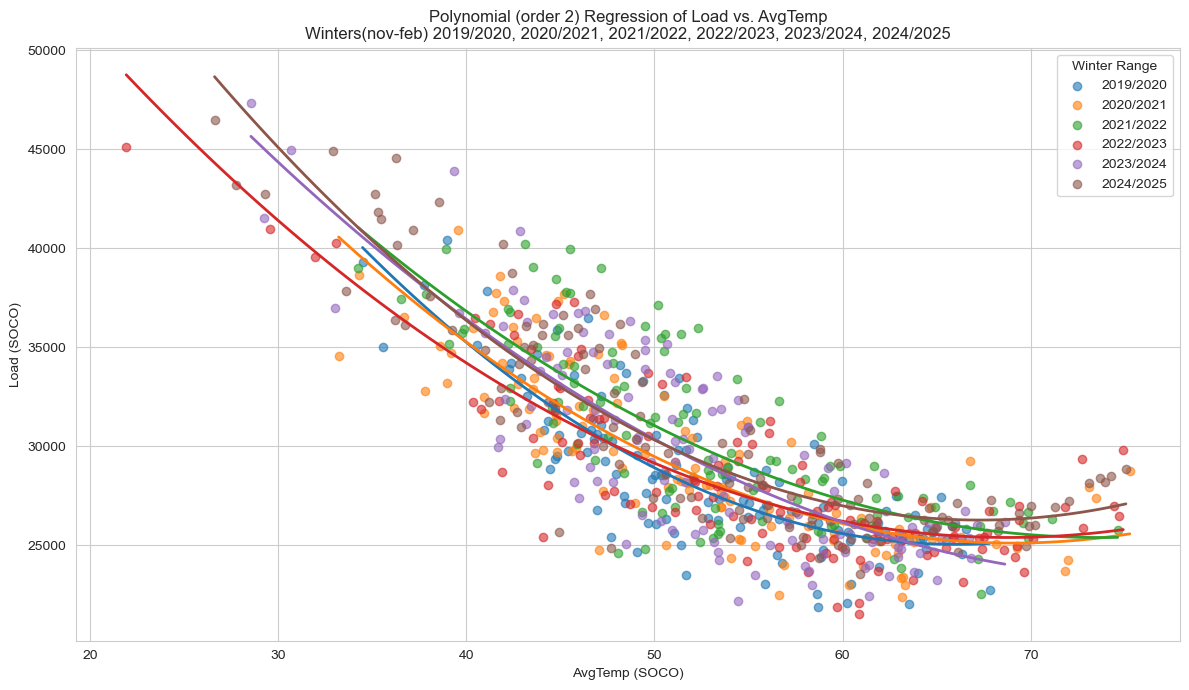

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_load_vs_weather_winter(
    df,
    winters,
    target_region,
    target_variable,
    polynomial_order=2
):
    """
    Plots scatter + polynomial regression of target_region's load vs. 
    target_region's target_variable for specified 'winter' seasons.

    :param df: DataFrame with columns:
               - 'DATE' (datetime),
               - region load columns (e.g. 'COAST', 'EAST', etc.),
               - region weather columns (e.g. 'COAST_MinTemp', etc.),
               - 'YEAR' (int) and 'MONTH' (int) can be added or assumed to exist
    :param winters: list of strings denoting winter ranges in "YYYY/YYYY" format,
                    e.g. ["2018/2019", "2019/2020"].  
                    - "2018/2019" means Nov & Dec 2018 plus Jan & Feb 2019.
    :param target_region: string, e.g. "COAST", "NORTH", etc.
    :param target_variable: string, e.g. "MinTemp", "MaxTemp", "HDD", "CDD", etc.
    :param polynomial_order: order of polynomial fit (int, e.g. 2).
    """

    # Ensure YEAR and MONTH columns exist
    if 'YEAR' not in df.columns or 'MONTH' not in df.columns:
        df['YEAR'] = df['DATE'].dt.year
        df['MONTH'] = df['DATE'].dt.month

    # Column names for x (weather) and y (load)
    weather_col = f'{target_region}_{target_variable}'
    load_col = target_region

    # Set up the figure
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 7))

    # Distinguish each winter by color
    palette = sns.color_palette('tab10', n_colors=len(winters))

    for i, winter_str in enumerate(winters):
        # Parse the "YYYY/YYYY" format
        start_year_str, next_year_str = winter_str.split('/')
        start_year = int(start_year_str)
        end_year = int(next_year_str)

        # Filter the DataFrame for Nov/Dec of start_year and Jan/Feb of end_year
        mask = (
            ((df['YEAR'] == start_year) & (df['MONTH'].isin([11, 12]))) |
            ((df['YEAR'] == end_year) & (df['MONTH'].isin([1, 2])))
        )
        winter_df = df[mask].dropna(subset=[weather_col, load_col])

        if winter_df.empty:
            print(f"No data for winter {winter_str}.")
            continue

        # Scatter plot
        plt.scatter(
            winter_df[weather_col],
            winter_df[load_col],
            alpha=0.6,
            color=palette[i],
            label=winter_str
        )

        # Polynomial regression
        z = np.polyfit(winter_df[weather_col], winter_df[load_col], polynomial_order)
        p = np.poly1d(z)

        # Plot regression line
        x_range = np.linspace(winter_df[weather_col].min(), winter_df[weather_col].max(), 100)
        plt.plot(x_range, p(x_range), color=palette[i], linewidth=2)

    # Labels and title
    plt.xlabel(f'{target_variable} ({target_region})')
    plt.ylabel(f'Load ({target_region})')
    plt.title(f'Polynomial (order {polynomial_order}) Regression of Load vs. {target_variable}\nWinters(nov-feb) {", ".join(winters)}')
    plt.legend(title='Winter Range')
    plt.tight_layout()
    plt.show()



# Example usage:
# Plot load vs. minimum temperature for COAST, comparing two winters:
plot_load_vs_weather_winter(
    df=combined_df,
    winters=["2019/2020", "2020/2021", "2021/2022", "2022/2023", "2023/2024", "2024/2025"],
    target_region="SOCO",
    target_variable="AvgTemp",
    polynomial_order=2
)


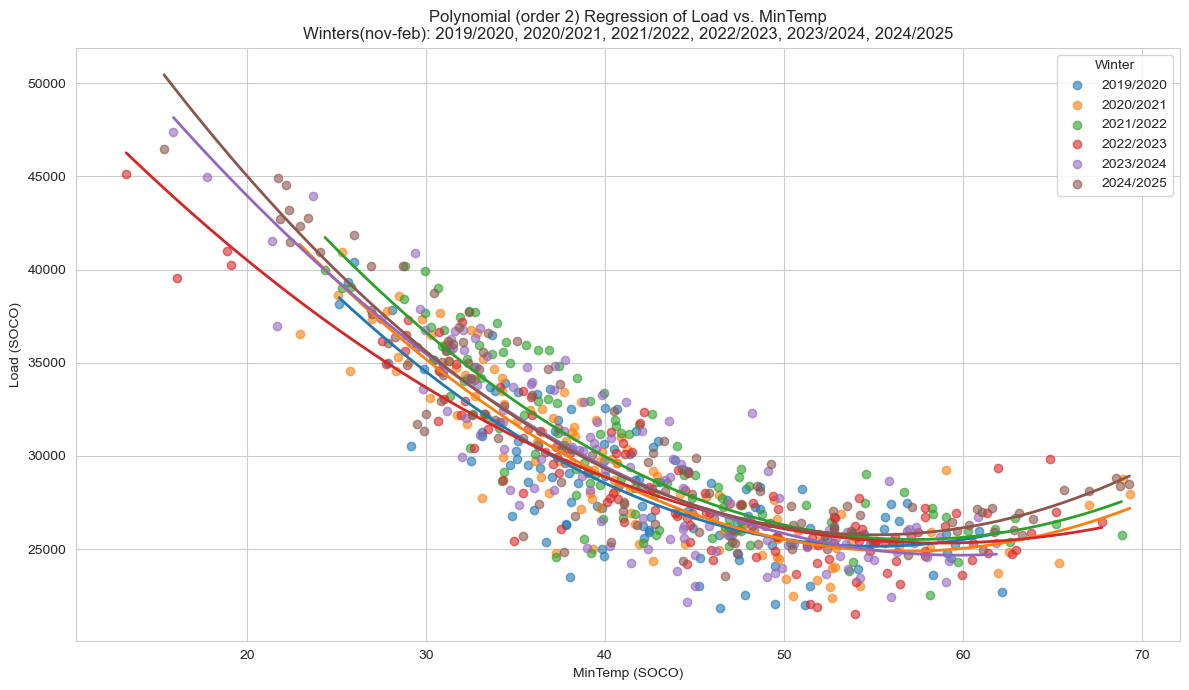

,Winter,IntegratedValue,YoY_AbsChange,YoY_PctChange
0,2019/2020,1.100877e+06,NaN,NaN
1,2020/2021,1.098345e+06,-2532.424083,-0.230037
2,2021/2022,1.132008e+06,33663.793670,3.064957
3,2022/2023,1.097815e+06,-34192.927424,-3.020554
4,2023/2024,1.098542e+06,726.104844,0.066141
5,2024/2025,1.130358e+06,31816.154519,2.896218


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def integrated_load_vs_weather_winter(
    df,
    winters,
    target_region,
    target_variable,
    polynomial_order=2,
    temp_min=20,
    temp_max=70
):
    """
    1. Plots scatter + polynomial regression of (region load) vs (region's target_variable)
       for specified 'winter' seasons.
    2. Integrates each fitted polynomial from temp_min to temp_max (area under the curve).
    3. Compares consecutive winters, computing absolute and percentage differences.
    4. Returns a DataFrame with integrated values and YoY changes.

    Parameters
    ----------
    df : pd.DataFrame
        Must have columns:
          - 'DATE' (datetime)
          - 'YEAR', 'MONTH' (or they will be created)
          - region load column (e.g. 'COAST')
          - region weather column (e.g. 'COAST_MinTemp', etc.)
    winters : list of str
        List of "YYYY/YYYY" strings, e.g. ["2018/2019", "2019/2020"]
        where "2018/2019" means Nov & Dec 2018 plus Jan & Feb 2019
    target_region : str
        E.g. "COAST", "NORTH", etc.
    target_variable : str
        E.g. "AvgTemp", "MinTemp", "MaxTemp", "HDD", etc.
    polynomial_order : int
        Order of polynomial fit (e.g. 2 for quadratic).
    temp_min : float
        Lower bound for integration (default 20°F).
    temp_max : float
        Upper bound for integration (default 70°F).

    Returns
    -------
    pd.DataFrame
        Columns:
          - Winter
          - IntegratedValue (area under the polynomial from temp_min to temp_max)
          - YoY_AbsChange (consecutive absolute change in integrated value)
          - YoY_PctChange (consecutive % change in integrated value)
    """

    # Ensure YEAR and MONTH exist
    if 'YEAR' not in df.columns or 'MONTH' not in df.columns:
        df['YEAR'] = df['DATE'].dt.year
        df['MONTH'] = df['DATE'].dt.month

    weather_col = f'{target_region}_{target_variable}'
    load_col = target_region

    # Prepare the plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 7))
    palette = sns.color_palette('tab10', n_colors=len(winters))

    # We'll store the fitted polynomials and their integrated values
    winter_polyfits = {}
    winter_integrals = {}

    sorted_winters = sorted(winters)  # sort for chronological ordering

    for i, winter_str in enumerate(sorted_winters):
        start_year_str, next_year_str = winter_str.split('/')
        start_year = int(start_year_str)
        end_year = int(next_year_str)

        # Filter for Nov/Dec of start_year and Jan/Feb of end_year
        mask = (
            ((df['YEAR'] == start_year) & (df['MONTH'].isin([11, 12]))) |
            ((df['YEAR'] == end_year) & (df['MONTH'].isin([1, 2])))
        )
        winter_df = df[mask].dropna(subset=[weather_col, load_col])

        if winter_df.empty:
            print(f"No data for winter {winter_str}.")
            continue

        # Scatter
        plt.scatter(
            winter_df[weather_col],
            winter_df[load_col],
            alpha=0.6,
            color=palette[i],
            label=winter_str
        )

        # Polynomial fit
        z = np.polyfit(winter_df[weather_col], winter_df[load_col], polynomial_order)
        p = np.poly1d(z)
        winter_polyfits[winter_str] = p

        # Plot regression line
        x_range = np.linspace(winter_df[weather_col].min(), winter_df[weather_col].max(), 100)
        plt.plot(x_range, p(x_range), color=palette[i], linewidth=2)

    # Finalize plot
    plt.xlabel(f'{target_variable} ({target_region})')
    plt.ylabel(f'Load ({target_region})')
    plt.title(
        f'Polynomial (order {polynomial_order}) Regression of Load vs. {target_variable}\n'
        f'Winters(nov-feb): {", ".join(sorted_winters)}'
    )
    plt.legend(title='Winter')
    plt.tight_layout()
    plt.show()

    # -------------------------------------------
    #  Compute Integrals and YoY Differences
    # -------------------------------------------
    data_rows = []
    for winter_str in sorted_winters:
        if winter_str not in winter_polyfits:
            # If no polynomial (empty data), store NaNs
            data_rows.append({
                'Winter': winter_str,
                'IntegratedValue': np.nan,
                'YoY_AbsChange': np.nan,
                'YoY_PctChange': np.nan
            })
            continue

        p = winter_polyfits[winter_str]
        p_int = p.integ()  # indefinite integral
        area = p_int(temp_max) - p_int(temp_min)  # definite integral in [temp_min, temp_max]
        winter_integrals[winter_str] = area

    # Now build a DataFrame with consecutive comparisons
    prev_winter = None
    for winter_str in sorted_winters:
        if winter_str not in winter_integrals:
            # store row with no data
            data_rows.append({
                'Winter': winter_str,
                'IntegratedValue': np.nan,
                'YoY_AbsChange': np.nan,
                'YoY_PctChange': np.nan
            })
            continue

        current_area = winter_integrals[winter_str]
        if prev_winter is None or (prev_winter not in winter_integrals):
            # first winter => no yoy comparison
            yoy_abs = np.nan
            yoy_pct = np.nan
        else:
            prev_area = winter_integrals[prev_winter]
            if pd.isna(prev_area) or prev_area == 0:
                yoy_abs = np.nan
                yoy_pct = np.nan
            else:
                yoy_abs = current_area - prev_area
                yoy_pct = (yoy_abs / prev_area) * 100

        data_rows.append({
            'Winter': winter_str,
            'IntegratedValue': current_area,
            'YoY_AbsChange': yoy_abs,
            'YoY_PctChange': yoy_pct
        })

        prev_winter = winter_str

    # Build final results DataFrame
    # We might have duplicates for each winter if we appended rows in the first loop
    # and second loop. To avoid that, we'll create a dictionary in a single pass:
    # but it's okay if you prefer a simpler approach. We'll handle it carefully:

    # We can do a simpler approach: just create in second loop. So let's revise:
    # We'll only create the final rows in the second loop, so we don't have duplicates.

    # Let's do that approach below, rewriting final steps more cleanly:

    final_data = []
    prev_winter = None
    for winter_str in sorted_winters:
        if winter_str not in winter_integrals:
            # no data => store NaN
            final_data.append({
                'Winter': winter_str,
                'IntegratedValue': np.nan,
                'YoY_AbsChange': np.nan,
                'YoY_PctChange': np.nan
            })
            continue

        current_area = winter_integrals[winter_str]
        if (prev_winter is None) or (prev_winter not in winter_integrals):
            yoy_abs = np.nan
            yoy_pct = np.nan
        else:
            prev_area = winter_integrals[prev_winter]
            if pd.isna(prev_area) or prev_area == 0:
                yoy_abs = np.nan
                yoy_pct = np.nan
            else:
                yoy_abs = current_area - prev_area
                yoy_pct = (yoy_abs / prev_area) * 100

        final_data.append({
            'Winter': winter_str,
            'IntegratedValue': current_area,
            'YoY_AbsChange': yoy_abs,
            'YoY_PctChange': yoy_pct
        })

        prev_winter = winter_str

    results_df = pd.DataFrame(final_data)
    # For clarity, let's keep the same order as sorted_winters
    results_df = results_df.set_index('Winter').reindex(sorted_winters).reset_index()

    return results_df




regions = [
    "SOCO"
]


for region in regions: 
    # Example usage:
    winters_list = ["2019/2020", "2020/2021", "2021/2022", "2022/2023", "2023/2024", "2024/2025"]
    results_df = integrated_load_vs_weather_winter(
        df=combined_df,
        winters=winters_list,
        target_region=region,
        target_variable="MinTemp",
        polynomial_order=2,
        temp_min=30,
        temp_max=70
    )
    display(results_df)




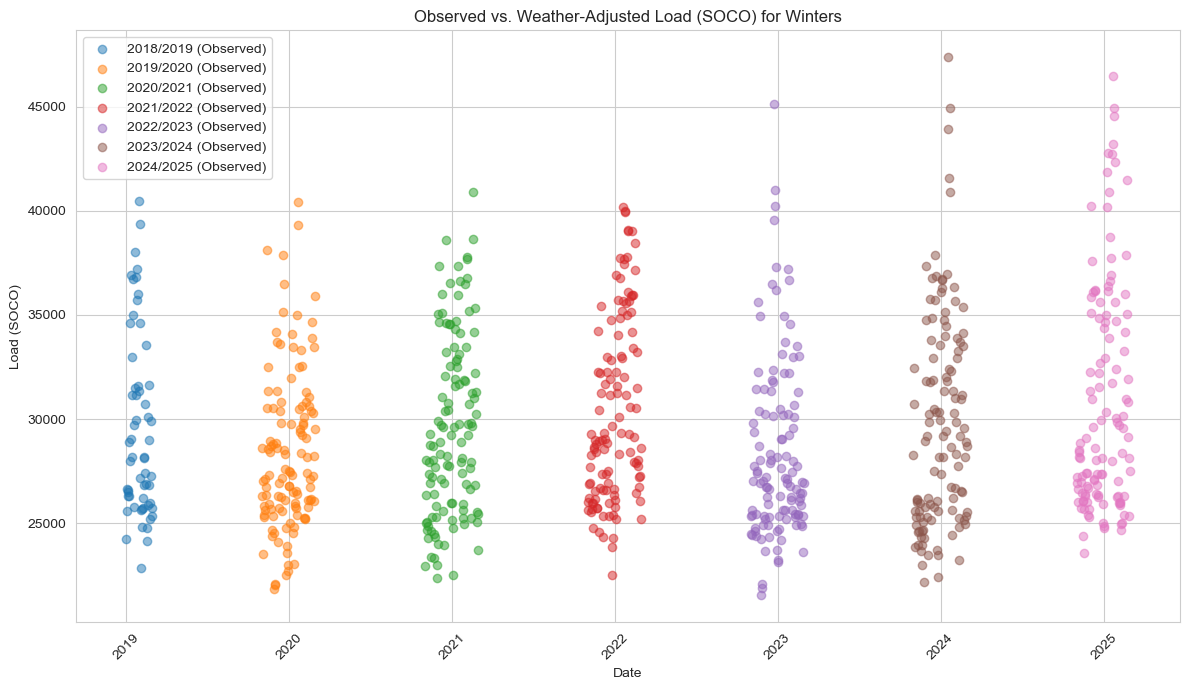

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def analyze_winter_load(df, region, weather_var, poly_order=2):
    # Define relevant columns
    weather_col = f'{region}_{weather_var}'
    load_col = region
    
    # Convert DATE column to datetime if not already
    df['DATE'] = pd.to_datetime(df['DATE'])
    df['MONTH'] = df['DATE'].dt.month
    df['YEAR'] = df['DATE'].dt.year

    # Identify winter years (Nov - Feb spans two years)
    df['Winter_Year'] = np.where(df['MONTH'] >= 11, 
                                 df['YEAR'], 
                                 df['YEAR'] - 1)
    
    df['Winter_Label'] = df['Winter_Year'].astype(str) + "/" + (df['Winter_Year'] + 1).astype(str)

    # Filter for only winter months (Nov-Feb)
    winter_df = df[df['MONTH'].isin([11, 12, 1, 2])].dropna(subset=[weather_col, load_col])

    # Polynomial regression to estimate weather-adjusted load
    X = winter_df[[weather_col]]
    y = winter_df[load_col]

    poly = PolynomialFeatures(poly_order)
    X_poly = poly.fit_transform(X)

    model = LinearRegression()
    model.fit(X_poly, y)

    # Predict adjusted load
    winter_df['Weather_Adjusted_Load'] = model.predict(X_poly)

    # Plot each winter separately
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 7))

    unique_winters = sorted(winter_df['Winter_Label'].unique())
    colors = sns.color_palette('tab10', n_colors=len(unique_winters))

    for i, winter in enumerate(unique_winters):
        subset = winter_df[winter_df['Winter_Label'] == winter]
        
        plt.scatter(subset['DATE'], subset[load_col], alpha=0.5, label=f"{winter} (Observed)", color=colors[i])
        # plt.plot(subset['DATE'], subset['Weather_Adjusted_Load'], linestyle="dashed", linewidth=2, label=f"{winter} (Adjusted)", color=colors[i])

    plt.xlabel('Date')
    plt.ylabel(f'Load ({region})')
    plt.title(f'Observed vs. Weather-Adjusted Load ({region}) for Winters')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return winter_df


regions = [
    "SOCO"
]

for region in regions:
# Example usage
    winter_data = analyze_winter_load(combined_df, region=region, weather_var='AvgTemp', poly_order=2)


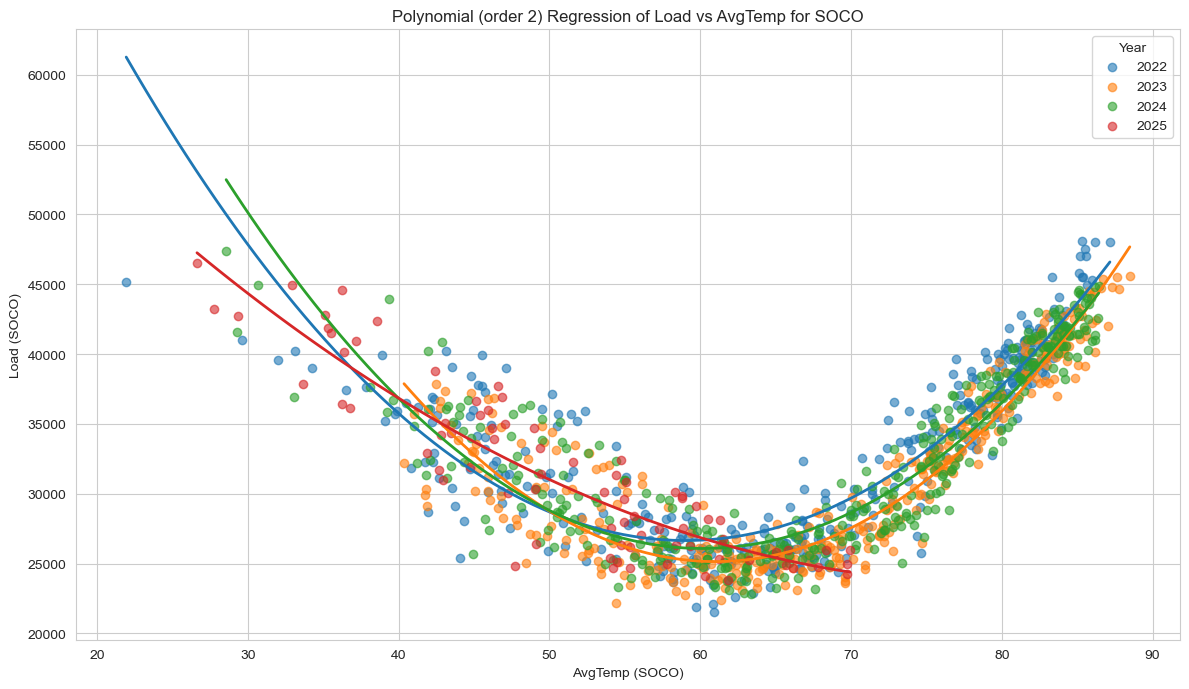

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_load_vs_weather(df, target_region, target_variable, polynomial_order=2, years=None, months=None):
    # Column names
    weather_col = f'{target_region}_{target_variable}'
    load_col = target_region

    # Extract year and month from DATE column
    df['YEAR'] = df['DATE'].dt.year
    df['MONTH'] = df['DATE'].dt.month

    # Filter based on years and months if provided
    if years is not None:
        df = df[df['YEAR'].isin(years)]
    if months is not None:
        df = df[df['MONTH'].isin(months)]

    # Set up plot aesthetics
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 7))

    unique_years = sorted(df['YEAR'].unique())
    colors = sns.color_palette('tab10', n_colors=len(unique_years))

    for i, year in enumerate(unique_years):
        yearly_data = df[df['YEAR'] == year].dropna(subset=[weather_col, load_col])

        # Scatter plot
        plt.scatter(
            yearly_data[weather_col],
            yearly_data[load_col],
            alpha=0.6,
            color=colors[i],
            label=f'{year}'
        )

        # Polynomial regression
        z = np.polyfit(yearly_data[weather_col], yearly_data[load_col], polynomial_order)
        p = np.poly1d(z)

        # Plot regression line
        x_range = np.linspace(yearly_data[weather_col].min(), yearly_data[weather_col].max(), 100)
        plt.plot(x_range, p(x_range), color=colors[i], linewidth=2)

    # Labels and title
    plt.xlabel(f'{target_variable} ({target_region})')
    plt.ylabel(f'Load ({target_region})')
    plt.title(f'Polynomial (order {polynomial_order}) Regression of Load vs {target_variable} for {target_region}')
    plt.legend(title='Year')
    plt.tight_layout()
    plt.show()


regions = [
    "SOCO"
]

# Example usage:
# plot_load_vs_weather(combined_df, 'PJM_TOTAL', 'AvgTemp', polynomial_order=2, years=[2022,2023,2024,2025], months=[1,2,3,4,5,6,7,8,9,10,11,12])

for region in regions:
    plot_load_vs_weather(combined_df, region, 'AvgTemp', polynomial_order=2, years=[2022,2023,2024,2025], months=[1,2,3,4,5,6,7,8,9,10,11,12])


In [16]:
import requests
import pandas as pd

def fetch_all_data():
    base_url = "https://api.eia.gov/v2/electricity/rto/daily-fuel-type-data/data/"
    api_key = "QPB6iXLFXYLNVdz2nhVAqFnbD6dVQjb5vNSKTANC"
    
    params = {
        "frequency": "daily",
        "data[0]": "value",
        # Note: Some fueltype values are repeated as provided.
        "facets[fueltype][]": [
            "BAT", "BAT", "COL", "GEO", "NG", "NUC", "OES", "OIL", "OTH",
            "PS", "PS", "SNB", "SNB", "SUN", "UES", "UES", "UNK", "WAT", "WNB", "WND"
        ],
        "facets[respondent][]": ["SOCO"],
        "start": "2019-01-01",
        "end": "2025-03-20",
        "sort[0][column]": "period",
        "sort[0][direction]": "desc",
        "offset": 0,
        "length": 5000,
        "api_key": api_key
    }
    
    # Initial API call
    response = requests.get(base_url, params=params)
    response.raise_for_status()
    json_data = response.json()
    
    total = int(json_data["response"]["total"])
    all_data = json_data["response"]["data"]
    print(f"Total rows to fetch: {total}")
    
    # Paginate if needed
    offset = 5000
    while offset < total:
        print(f"Fetching offset: {offset}")
        params["offset"] = offset
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        page_data = response.json()["response"]["data"]
        if not page_data:
            break
        all_data.extend(page_data)
        offset += 5000
        
    return all_data

# Fetch data and load into DataFrame
data = fetch_all_data()
df = pd.DataFrame(data)

# Convert 'period' to datetime and 'value' to numeric
df['period'] = pd.to_datetime(df['period'], errors='coerce')
df['value'] = pd.to_numeric(df['value'], errors='coerce')

# Pivot the DataFrame so that each row is a single day (period)
# and each fueltype becomes its own column.
# In case of duplicates, we use the first value.
pivot_df = df.pivot_table(index='period', columns='fueltype', values='value', aggfunc='first')

# Reset index so that period becomes a column, and rename it to 'DATE' if desired.
pivot_df = pivot_df.reset_index().rename(columns={'period': 'DATE'})

# Display a sample of the pivoted DataFrame
print(pivot_df.head())
pd.set_option('display.max_columns', None)

# Optionally, save the pivoted data to a CSV file
pivot_df


Total rows to fetch: 91901
Fetching offset: 5000
Fetching offset: 10000
Fetching offset: 15000
Fetching offset: 20000
Fetching offset: 25000
Fetching offset: 30000
Fetching offset: 35000
Fetching offset: 40000
Fetching offset: 45000
Fetching offset: 50000
Fetching offset: 55000
Fetching offset: 60000
Fetching offset: 65000
Fetching offset: 70000
Fetching offset: 75000
Fetching offset: 80000
Fetching offset: 85000
Fetching offset: 90000
fueltype       DATE  BAT       COL        NG       NUC  OES   OIL     OTH  PS  \
0        2019-01-01  NaN  133444.0  179038.0  140585.0  NaN -14.0  4605.0 NaN   
1        2019-01-02  NaN  140934.0  238852.0  141294.0  NaN  35.0  4899.0 NaN   
2        2019-01-03  NaN  143630.0  249086.0  141211.0  NaN -18.0  5024.0 NaN   
3        2019-01-04  NaN  120407.0  271363.0  141410.0  NaN -15.0  4772.0 NaN   
4        2019-01-05  NaN  113625.0  267280.0  142219.0  NaN -14.0  4869.0 NaN   

fueltype  SNB     SUN      WAT  WND  
0         NaN  2429.0  52556.0  0.0

fueltype,DATE,BAT,COL,NG,NUC,OES,OIL,OTH,PS,SNB,SUN,WAT,WND
0,2019-01-01,NaN,133444.0,179038.0,140585.0,NaN,-14.0,4605.0,NaN,NaN,2429.0,52556.0,0.0
1,2019-01-02,NaN,140934.0,238852.0,141294.0,NaN,35.0,4899.0,NaN,NaN,1824.0,54226.0,0.0
2,2019-01-03,NaN,143630.0,249086.0,141211.0,NaN,-18.0,5024.0,NaN,NaN,1493.0,55607.0,0.0
3,2019-01-04,NaN,120407.0,271363.0,141410.0,NaN,-15.0,4772.0,NaN,NaN,2504.0,56112.0,0.0
4,2019-01-05,NaN,113625.0,267280.0,142219.0,NaN,-14.0,4869.0,NaN,NaN,7401.0,56623.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266,2025-03-16,-81.0,65073.0,237086.0,125630.0,0.0,-11.0,1199.0,-1657.0,0.0,14237.0,35578.0,0.0
2267,2025-03-17,-59.0,67252.0,272206.0,130319.0,0.0,-15.0,1290.0,-1005.0,0.0,20354.0,38598.0,0.0
2268,2025-03-18,-37.0,66064.0,278650.0,137706.0,0.0,89.0,1325.0,154.0,0.0,20249.0,40342.0,0.0
2269,2025-03-19,91.0,64335.0,267252.0,144519.0,0.0,-14.0,1360.0,306.0,3.0,21450.0,38152.0,0.0


In [17]:
import pandas as pd

# Ensure the pivoted DataFrame has no index/column name (drop "fueltype" if present)
pivot_df.index.name = None
pivot_df.columns.name = None

# Identify the fuel type columns (all columns except 'DATE')
fuel_cols = pivot_df.columns.drop('DATE')

# Compute total generation per row using the fuel type columns
pivot_df['TOTAL_GEN'] = pivot_df[fuel_cols].sum(axis=1)

# For each fuel type, create a new column showing its percentage of total generation
for col in fuel_cols:
    new_col = f"{col}RATIO"
    pivot_df[new_col] = (pivot_df[col] / pivot_df['TOTAL_GEN']) * 100

# Optionally, drop the temporary TOTAL_GEN column if not needed
pivot_df = pivot_df.drop(columns='TOTAL_GEN')

# Display the updated DataFrame
pivot_df


,DATE,BAT,COL,NG,NUC,OES,OIL,OTH,PS,SNB,SUN,WAT,WND,BATRATIO,COLRATIO,NGRATIO,NUCRATIO,OESRATIO,OILRATIO,OTHRATIO,PSRATIO,SNBRATIO,SUNRATIO,WATRATIO,WNDRATIO
0,2019-01-01,NaN,133444.0,179038.0,140585.0,NaN,-14.0,4605.0,NaN,NaN,2429.0,52556.0,0.0,NaN,26.030590,34.924499,27.423568,NaN,-0.002731,0.898286,NaN,NaN,0.473819,10.251969,0.0
1,2019-01-02,NaN,140934.0,238852.0,141294.0,NaN,35.0,4899.0,NaN,NaN,1824.0,54226.0,0.0,NaN,24.212801,41.035350,24.274650,NaN,0.006013,0.841660,NaN,NaN,0.313368,9.316158,0.0
2,2019-01-03,NaN,143630.0,249086.0,141211.0,NaN,-18.0,5024.0,NaN,NaN,1493.0,55607.0,0.0,NaN,24.097659,41.790639,23.691809,NaN,-0.003020,0.842906,NaN,NaN,0.250489,9.329517,0.0
3,2019-01-04,NaN,120407.0,271363.0,141410.0,NaN,-15.0,4772.0,NaN,NaN,2504.0,56112.0,0.0,NaN,20.183789,45.488498,23.704516,NaN,-0.002514,0.799929,NaN,NaN,0.419745,9.406038,0.0
4,2019-01-05,NaN,113625.0,267280.0,142219.0,NaN,-14.0,4869.0,NaN,NaN,7401.0,56623.0,0.0,NaN,19.193315,45.148420,24.023358,NaN,-0.002365,0.822462,NaN,NaN,1.250163,9.564647,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266,2025-03-16,-81.0,65073.0,237086.0,125630.0,0.0,-11.0,1199.0,-1657.0,0.0,14237.0,35578.0,0.0,-0.016979,13.640594,49.697938,26.334545,0.0,-0.002306,0.251334,-0.347340,0.000000,2.984358,7.457856,0.0
2267,2025-03-17,-59.0,67252.0,272206.0,130319.0,0.0,-15.0,1290.0,-1005.0,0.0,20354.0,38598.0,0.0,-0.011154,12.714486,51.462548,24.637766,0.0,-0.002836,0.243884,-0.190003,0.000000,3.848074,7.297236,0.0
2268,2025-03-18,-37.0,66064.0,278650.0,137706.0,0.0,89.0,1325.0,154.0,0.0,20249.0,40342.0,0.0,-0.006795,12.132030,51.171443,25.288408,0.0,0.016344,0.243324,0.028281,0.000000,3.718538,7.408428,0.0
2269,2025-03-19,91.0,64335.0,267252.0,144519.0,0.0,-14.0,1360.0,306.0,3.0,21450.0,38152.0,0.0,0.016932,11.970327,49.725558,26.889557,0.0,-0.002605,0.253045,0.056935,0.000558,3.991039,7.098654,0.0


In [18]:
import pandas as pd

# Ensure DATE columns are datetime
pivot_df['DATE'] = pd.to_datetime(pivot_df['DATE'])
stations['date'] = pd.to_datetime(stations['date'])

# Metrics to aggregate
metrics = ['MinTemp', 'MaxTemp', 'HDD', 'CDD', 'AvgTemp', 'TotalDD']

region_weights = {
    "BAT": SOCO,
    "COL": SOCO,
    "NG": SOCO,
    "NUC": SOCO,
    "OES": SOCO,
    "OIL": SOCO,
    "OTH": SOCO,
    "PS": SOCO,
    "SNB": SOCO,
    "SUN": SOCO,
    "WAT": SOCO,
    "WND": SOCO,
    "BATRATIO": SOCO,
    "COLRATIO": SOCO,
    "NGRATIO": SOCO,
    "NUCRATIO": SOCO,
    "OESRATIO": SOCO,
    "OILRATIO": SOCO,
    "OTHRATIO": SOCO,
    "PSRATIO": SOCO,
    "SNBRATIO": SOCO,
    "SUNRATIO": SOCO,
    "WATRATIO": SOCO,
    "WNDRATIO": SOCO
}
combined_df_gen = pivot_df.copy()

# For each metric and region, compute the weighted average and map it into combined_df_gen
for metric in metrics:
    for region, weights in region_weights.items():
        # Extract relevant stations
        region_stations = stations[stations['station'].isin(weights.keys())]
        
        # Compute weighted average per day as a Series with 'date' as its index
        weighted_avg = (
            region_stations
            .assign(weight=region_stations['station'].map(weights))
            .groupby('date')
            .apply(lambda x: (x[metric] * x['weight']).sum() / x['weight'].sum())
        )
        
        # Map the computed weighted average to the daily_load DataFrame based on DATE
        combined_df_gen[f'{region}_{metric}'] = combined_df_gen['DATE'].map(weighted_avg)

# Display result
combined_df_gen

,DATE,BAT,COL,NG,NUC,OES,OIL,OTH,PS,SNB,SUN,WAT,WND,BATRATIO,COLRATIO,NGRATIO,NUCRATIO,OESRATIO,OILRATIO,OTHRATIO,PSRATIO,SNBRATIO,SUNRATIO,WATRATIO,WNDRATIO,BAT_MinTemp,COL_MinTemp,NG_MinTemp,NUC_MinTemp,OES_MinTemp,OIL_MinTemp,OTH_MinTemp,PS_MinTemp,SNB_MinTemp,SUN_MinTemp,WAT_MinTemp,WND_MinTemp,BATRATIO_MinTemp,COLRATIO_MinTemp,NGRATIO_MinTemp,NUCRATIO_MinTemp,OESRATIO_MinTemp,OILRATIO_MinTemp,OTHRATIO_MinTemp,PSRATIO_MinTemp,SNBRATIO_MinTemp,SUNRATIO_MinTemp,WATRATIO_MinTemp,WNDRATIO_MinTemp,BAT_MaxTemp,COL_MaxTemp,NG_MaxTemp,NUC_MaxTemp,OES_MaxTemp,OIL_MaxTemp,OTH_MaxTemp,PS_MaxTemp,SNB_MaxTemp,SUN_MaxTemp,WAT_MaxTemp,WND_MaxTemp,BATRATIO_MaxTemp,COLRATIO_MaxTemp,NGRATIO_MaxTemp,NUCRATIO_MaxTemp,OESRATIO_MaxTemp,OILRATIO_MaxTemp,OTHRATIO_MaxTemp,PSRATIO_MaxTemp,SNBRATIO_MaxTemp,SUNRATIO_MaxTemp,WATRATIO_MaxTemp,WNDRATIO_MaxTemp,BAT_HDD,COL_HDD,NG_HDD,NUC_HDD,OES_HDD,OIL_HDD,OTH_HDD,PS_HDD,SNB_HDD,SUN_HDD,WAT_HDD,WND_HDD,BATRATIO_HDD,COLRATIO_HDD,NGRATIO_HDD,NUCRATIO_HDD,OESRATIO_HDD,OILRATIO_HDD,OTHRATIO_HDD,PSRATIO_HDD,SNBRATIO_HDD,SUNRATIO_HDD,WATRATIO_HDD,WNDRATIO_HDD,BAT_CDD,COL_CDD,NG_CDD,NUC_CDD,OES_CDD,OIL_CDD,OTH_CDD,PS_CDD,SNB_CDD,SUN_CDD,WAT_CDD,WND_CDD,BATRATIO_CDD,COLRATIO_CDD,NGRATIO_CDD,NUCRATIO_CDD,OESRATIO_CDD,OILRATIO_CDD,OTHRATIO_CDD,PSRATIO_CDD,SNBRATIO_CDD,SUNRATIO_CDD,WATRATIO_CDD,WNDRATIO_CDD,BAT_AvgTemp,COL_AvgTemp,NG_AvgTemp,NUC_AvgTemp,OES_AvgTemp,OIL_AvgTemp,OTH_AvgTemp,PS_AvgTemp,SNB_AvgTemp,SUN_AvgTemp,WAT_AvgTemp,WND_AvgTemp,BATRATIO_AvgTemp,COLRATIO_AvgTemp,NGRATIO_AvgTemp,NUCRATIO_AvgTemp,OESRATIO_AvgTemp,OILRATIO_AvgTemp,OTHRATIO_AvgTemp,PSRATIO_AvgTemp,SNBRATIO_AvgTemp,SUNRATIO_AvgTemp,WATRATIO_AvgTemp,WNDRATIO_AvgTemp,BAT_TotalDD,COL_TotalDD,NG_TotalDD,NUC_TotalDD,OES_TotalDD,OIL_TotalDD,OTH_TotalDD,PS_TotalDD,SNB_TotalDD,SUN_TotalDD,WAT_TotalDD,WND_TotalDD,BATRATIO_TotalDD,COLRATIO_TotalDD,NGRATIO_TotalDD,NUCRATIO_TotalDD,OESRATIO_TotalDD,OILRATIO_TotalDD,OTHRATIO_TotalDD,PSRATIO_TotalDD,SNBRATIO_TotalDD,SUNRATIO_TotalDD,WATRATIO_TotalDD,WNDRATIO_TotalDD
0,2019-01-01,NaN,133444.0,179038.0,140585.0,NaN,-14.0,4605.0,NaN,NaN,2429.0,52556.0,0.0,NaN,26.030590,34.924499,27.423568,NaN,-0.002731,0.898286,NaN,NaN,0.473819,10.251969,0.0,58.277,58.277,58.277,58.277,58.277,58.277,58.277,58.277,58.277,58.277,58.277,58.277,58.277,58.277,58.277,58.277,58.277,58.277,58.277,58.277,58.277,58.277,58.277,58.277,69.697,69.697,69.697,69.697,69.697,69.697,69.697,69.697,69.697,69.697,69.697,69.697,69.697,69.697,69.697,69.697,69.697,69.697,69.697,69.697,69.697,69.697,69.697,69.697,3.300,3.300,3.300,3.300,3.300,3.300,3.300,3.300,3.300,3.300,3.300,3.300,3.300,3.300,3.300,3.300,3.300,3.300,3.300,3.300,3.300,3.300,3.300,3.300,2.124,2.124,2.124,2.124,2.124,2.124,2.124,2.124,2.124,2.124,2.124,2.124,2.124,2.124,2.124,2.124,2.124,2.124,2.124,2.124,2.124,2.124,2.124,2.124,63.9870,63.9870,63.9870,63.9870,63.9870,63.9870,63.9870,63.9870,63.9870,63.9870,63.9870,63.9870,63.9870,63.9870,63.9870,63.9870,63.9870,63.9870,63.9870,63.9870,63.9870,63.9870,63.9870,63.9870,5.424,5.424,5.424,5.424,5.424,5.424,5.424,5.424,5.424,5.424,5.424,5.424,5.424,5.424,5.424,5.424,5.424,5.424,5.424,5.424,5.424,5.424,5.424,5.424
1,2019-01-02,NaN,140934.0,238852.0,141294.0,NaN,35.0,4899.0,NaN,NaN,1824.0,54226.0,0.0,NaN,24.212801,41.035350,24.274650,NaN,0.006013,0.841660,NaN,NaN,0.313368,9.316158,0.0,53.224,53.224,53.224,53.224,53.224,53.224,53.224,53.224,53.224,53.224,53.224,53.224,53.224,53.224,53.224,53.224,53.224,53.224,53.224,53.224,53.224,53.224,53.224,53.224,62.574,62.574,62.574,62.574,62.574,62.574,62.574,62.574,62.574,62.574,62.574,62.574,62.574,62.574,62.574,62.574,62.574,62.574,62.574,62.574,62.574,62.574,62.574,62.574,7.927,7.927,7.927,7.927,7.927,7.927,7.927,7.927,7.927,7.927,7.927,7.927,7.927,7.927,7.927,7.927,7.927,7.927,7.927,7.927,7.927,7.927,7.927,7.927,0.826,0.826,0.826,0.826,0.826,0.826,0.826,0.826,0.826,0.826,0.826,0.826,0.826,0.826,0.826,0.826,0.826,0.826,0.826,0.826,0.826,0.826,0.826,0.826,57.8990,57.8990,57.8990,57.8990,57.89

Natural gas winter daily total winter gen vs avg temp


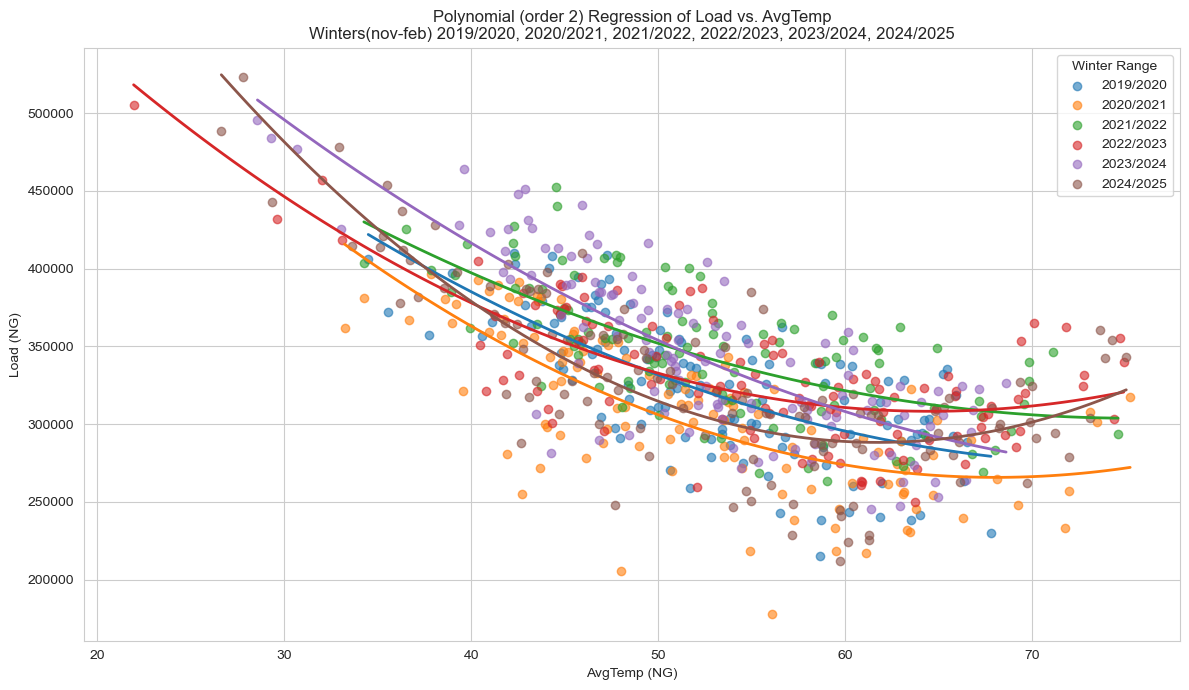

In [20]:
print("Natural gas winter daily total winter gen vs avg temp")
plot_load_vs_weather_winter(
    df=combined_df_gen,
    winters=["2019/2020", "2020/2021", "2021/2022", "2022/2023", "2023/2024", "2024/2025"],
    target_region="NG",
    target_variable="AvgTemp",
    polynomial_order=2
)

Natural gas winter daily total winter gen vs avg temp with growth YoY


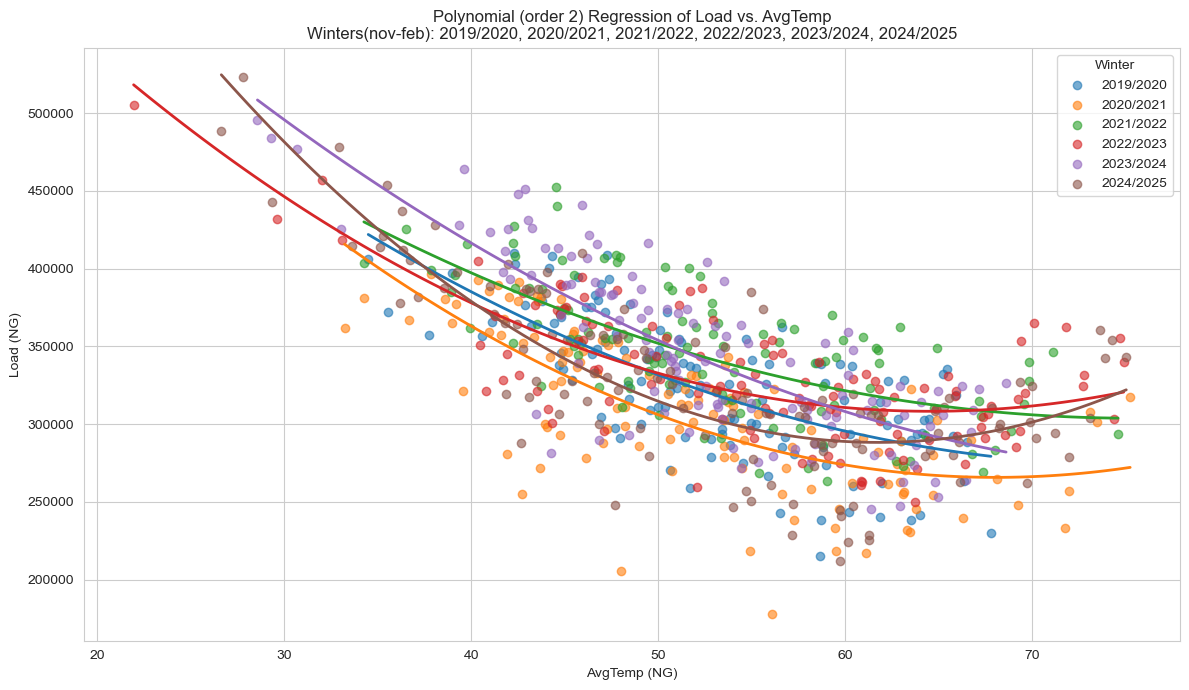

,Winter,IntegratedValue,YoY_AbsChange,YoY_PctChange
0,2019/2020,1.372831e+07,NaN,NaN
1,2020/2021,1.290077e+07,-8.275431e+05,-6.028004
2,2021/2022,1.447608e+07,1.575315e+06,12.211021
3,2022/2023,1.392685e+07,-5.492337e+05,-3.794077
4,2023/2024,1.460345e+07,6.766021e+05,4.858256
5,2024/2025,1.361086e+07,-9.925927e+05,-6.796974


Natural gas winter daily total winter gen as percentage of total  vs avg temp with growth YoY


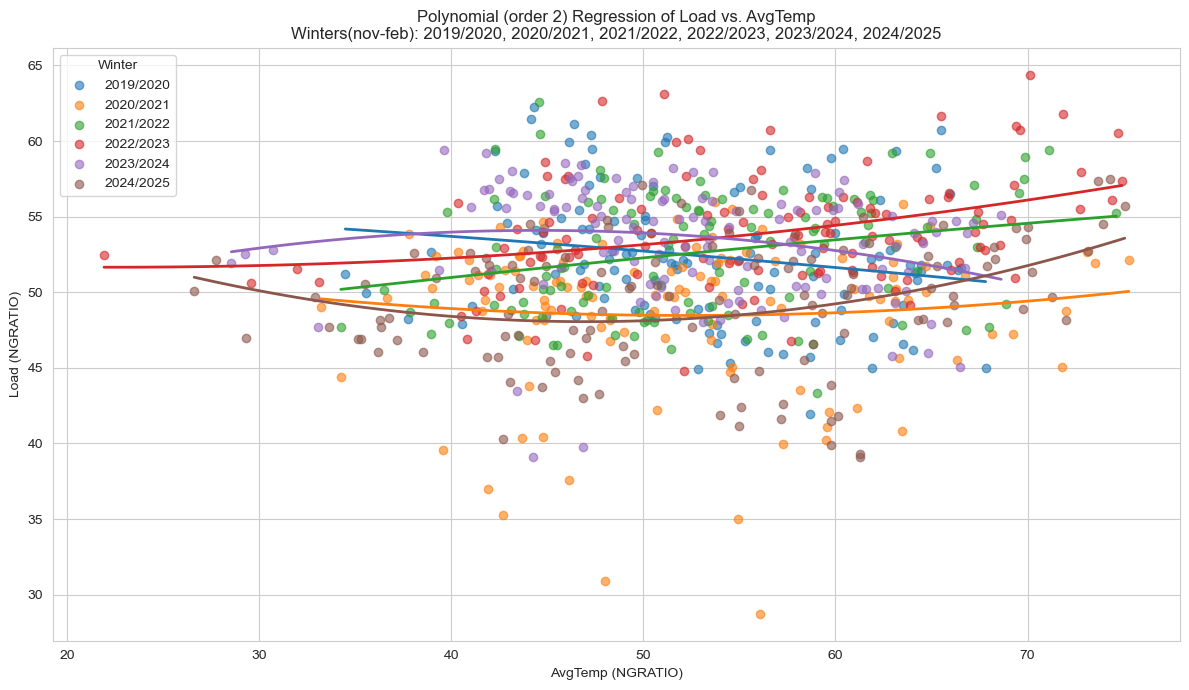

,Winter,IntegratedValue,YoY_AbsChange,YoY_PctChange
0,2019/2020,2105.769499,NaN,NaN
1,2020/2021,1955.237632,-150.531866,-7.148544
2,2021/2022,2088.155672,132.918040,6.798050
3,2022/2023,2136.227127,48.071455,2.302101
4,2023/2024,2127.221479,-9.005648,-0.421568
5,2024/2025,1962.096575,-165.124904,-7.762469


In [ ]:
print("Natural gas winter daily total winter gen vs avg temp with growth YoY")
results_df = integrated_load_vs_weather_winter(
        df=combined_df_gen,
        winters=["2019/2020", "2020/2021", "2021/2022", "2022/2023", "2023/2024", "2024/2025"],
        target_region="NG",
        target_variable="AvgTemp",
        polynomial_order=2,
        temp_min=30,
        temp_max=70
    )
display(results_df)

# appears to stronger geowth in gas gen with extreme colder and warmer winter temps but softer in mid temp range

print("Natural gas winter daily total winter gen as percentage of total  vs avg temp with growth YoY")
results_df = integrated_load_vs_weather_winter(
        df=combined_df_gen,
        winters=["2019/2020", "2020/2021", "2021/2022", "2022/2023", "2023/2024", "2024/2025"],
        target_region="NGRATIO",
        target_variable="AvgTemp",
        polynomial_order=2,
        temp_min=30,
        temp_max=70
    )
display(results_df)

Natural gas winter daily total winter gen vs avg temp with growth YoY


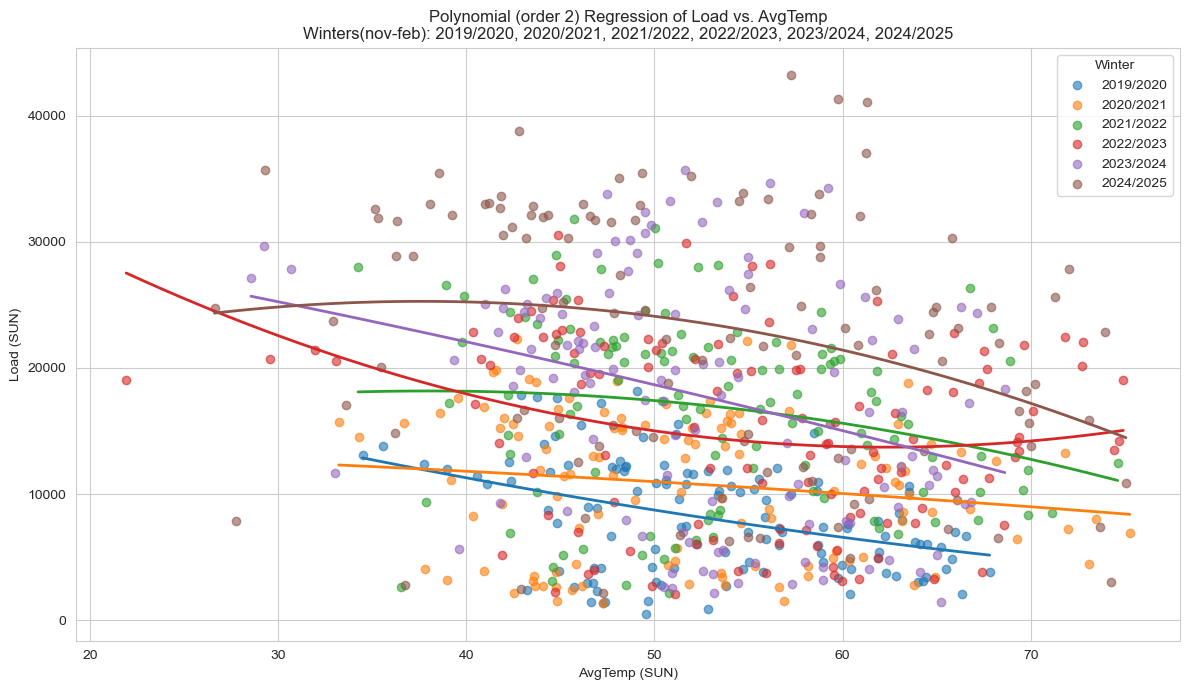

,Winter,IntegratedValue,YoY_AbsChange,YoY_PctChange
0,2019/2020,360099.161429,NaN,NaN
1,2020/2021,436449.962351,76350.800922,21.202716
2,2021/2022,668293.354979,231843.392629,53.120269
3,2022/2023,645575.706034,-22717.648945,-3.399353
4,2023/2024,740556.369117,94980.663082,14.712552
5,2024/2025,922728.976572,182172.607455,24.599425


Natural gas winter daily total winter gen as percentage of total  vs avg temp with growth YoY


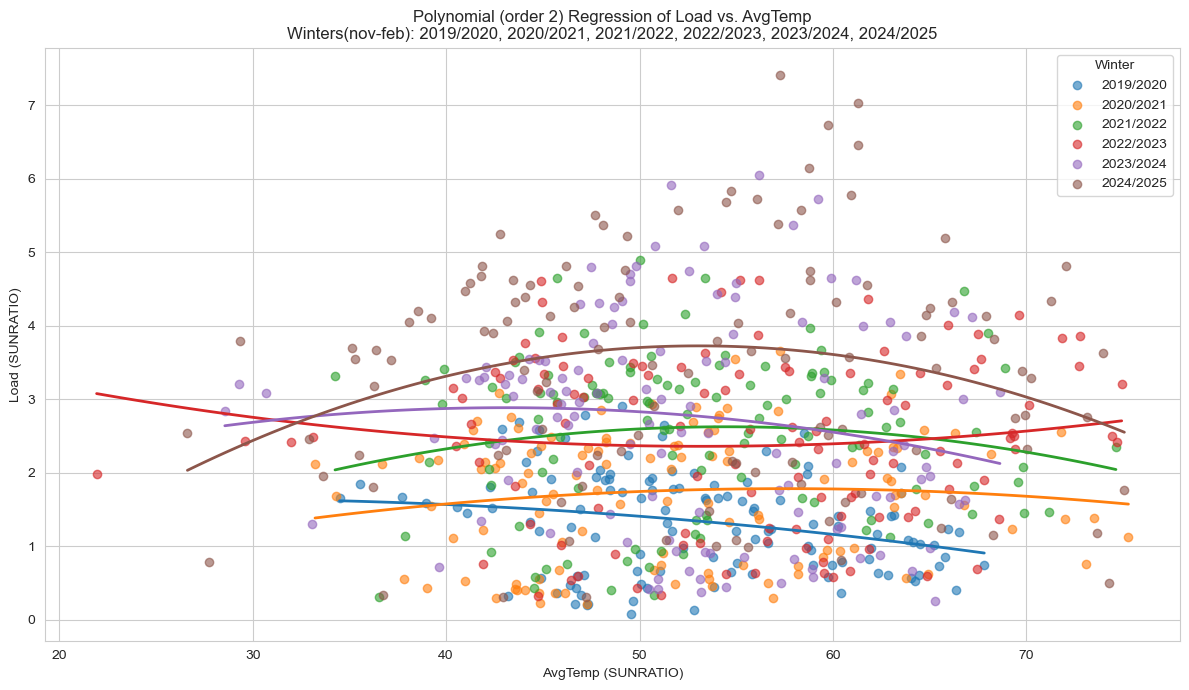

,Winter,IntegratedValue,YoY_AbsChange,YoY_PctChange
0,2019/2020,54.015738,NaN,NaN
1,2020/2021,66.216959,12.201221,22.588270
2,2021/2022,96.232723,30.015764,45.329421
3,2022/2023,98.615136,2.382413,2.475679
4,2023/2024,106.986829,8.371693,8.489257
5,2024/2025,135.226509,28.239680,26.395473


In [22]:
print("Natural gas winter daily total winter gen vs avg temp with growth YoY")
results_df = integrated_load_vs_weather_winter(
        df=combined_df_gen,
        winters=["2019/2020", "2020/2021", "2021/2022", "2022/2023", "2023/2024", "2024/2025"],
        target_region="SUN",
        target_variable="AvgTemp",
        polynomial_order=2,
        temp_min=30,
        temp_max=70
    )
display(results_df)

# appears to stronger geowth in gas gen with extreme colder and warmer winter temps but softer in mid temp range

print("Natural gas winter daily total winter gen as percentage of total  vs avg temp with growth YoY")
results_df = integrated_load_vs_weather_winter(
        df=combined_df_gen,
        winters=["2019/2020", "2020/2021", "2021/2022", "2022/2023", "2023/2024", "2024/2025"],
        target_region="SUNRATIO",
        target_variable="AvgTemp",
        polynomial_order=2,
        temp_min=30,
        temp_max=70
    )
display(results_df)

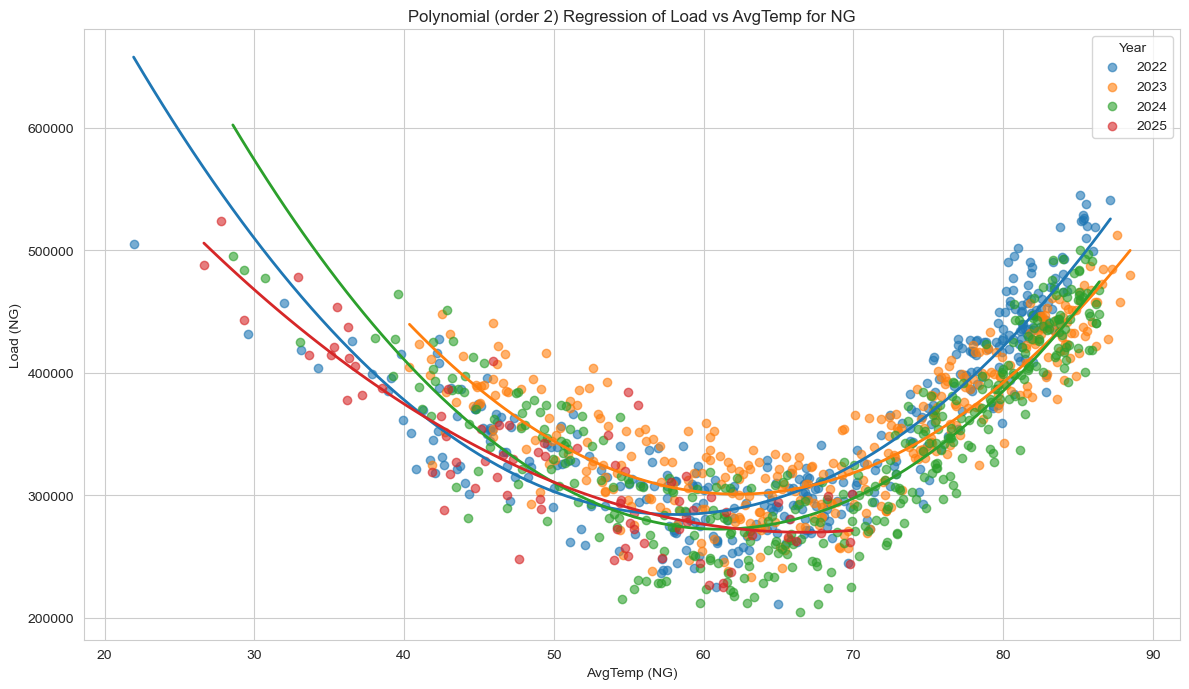

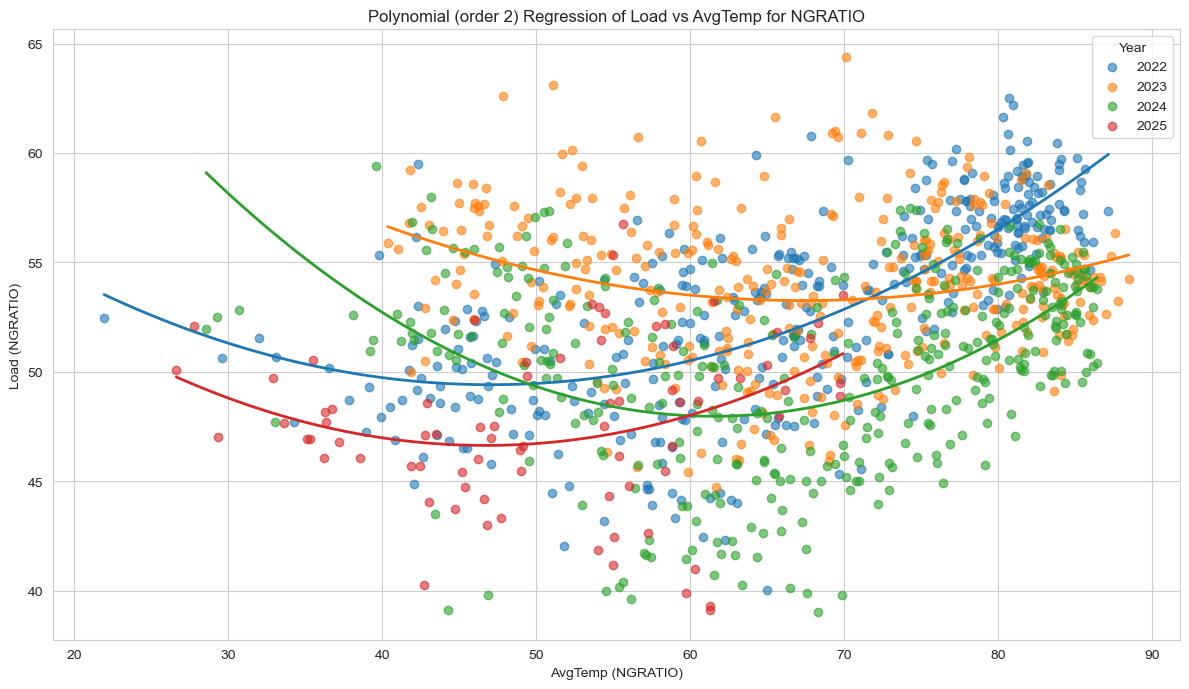

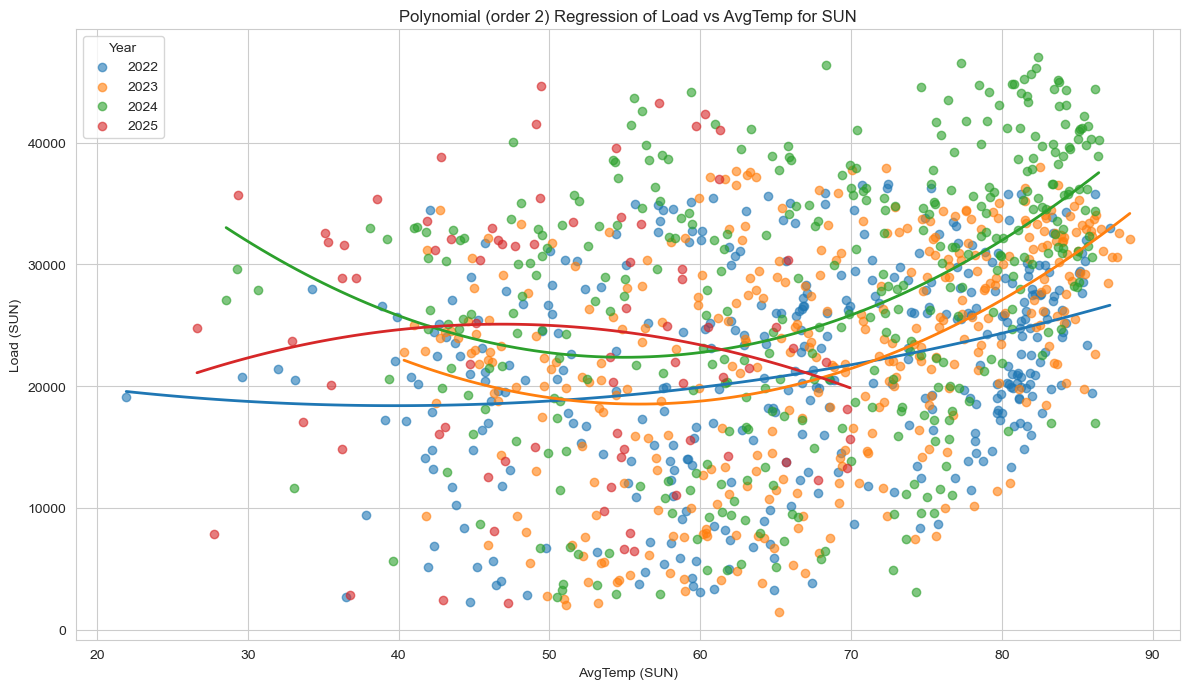

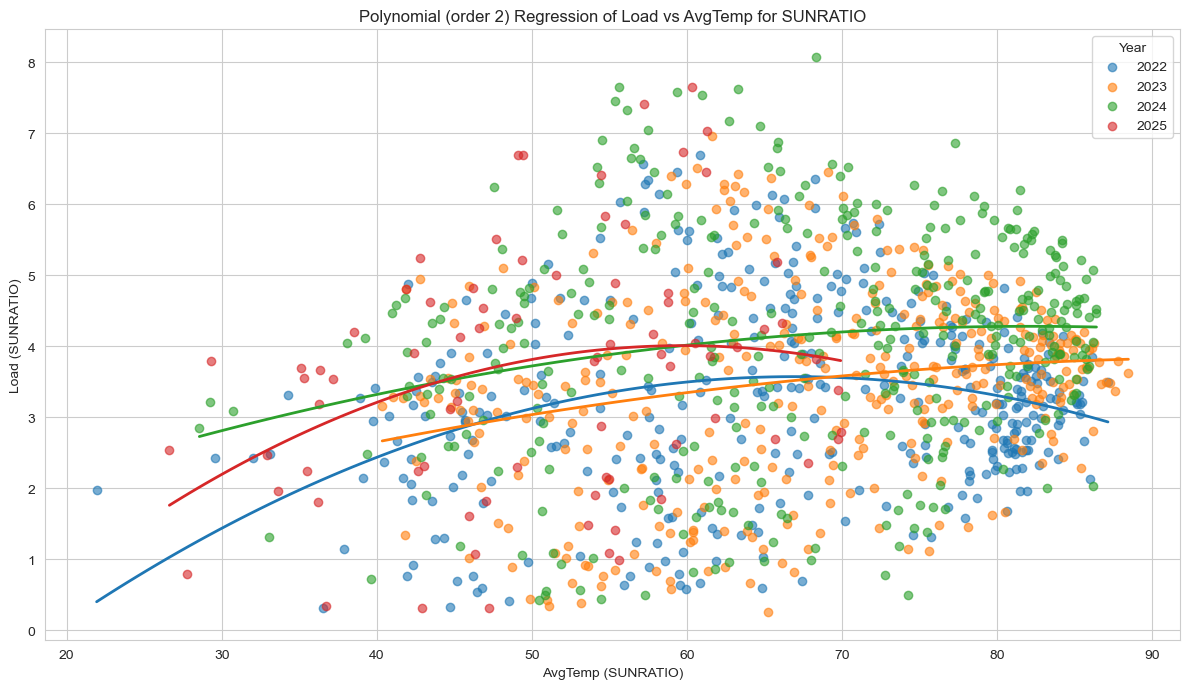

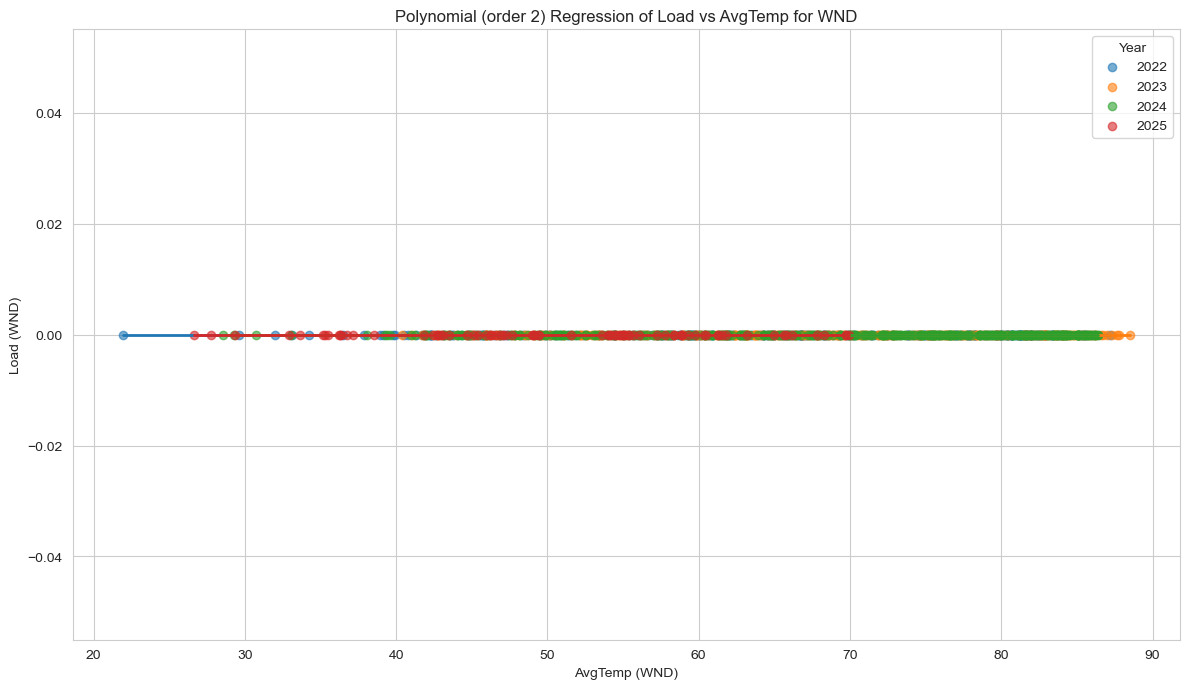

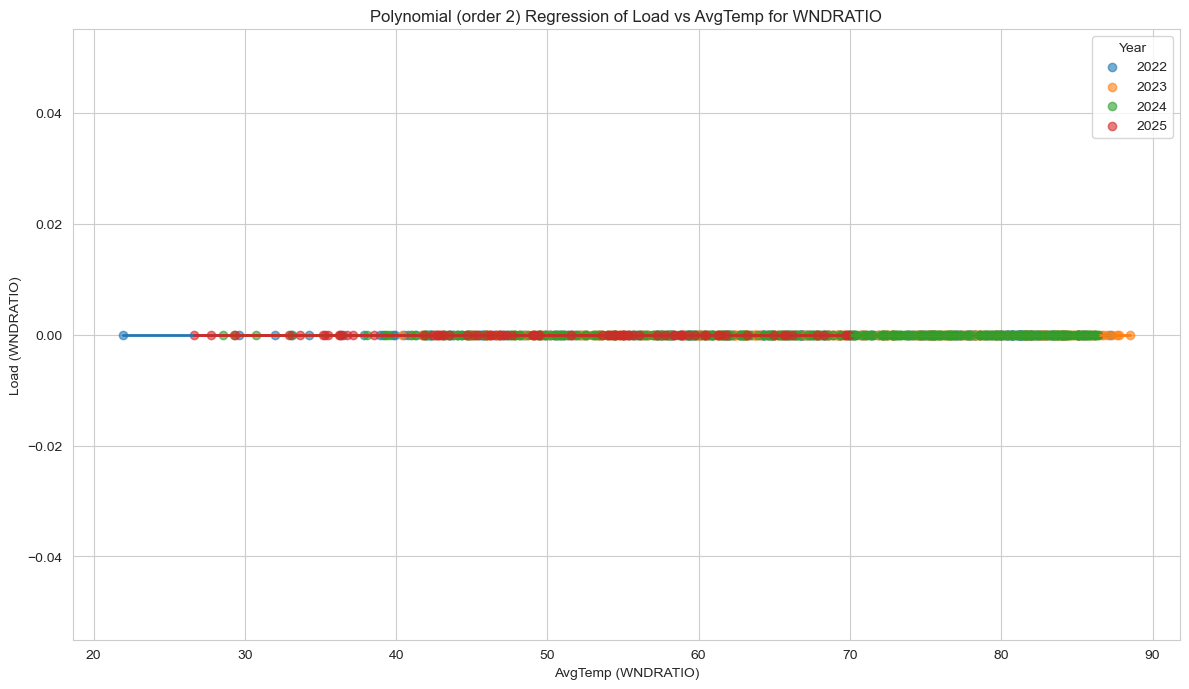

In [24]:
regions = [
    "NG", "NGRATIO", "SUN", "SUNRATIO", "WND", "WNDRATIO"
]

# Example usage:
# plot_load_vs_weather(combined_df, 'PJM_TOTAL', 'AvgTemp', polynomial_order=2, years=[2022,2023,2024,2025], months=[1,2,3,4,5,6,7,8,9,10,11,12])

for region in regions:
    plot_load_vs_weather(combined_df_gen, region, 'AvgTemp', polynomial_order=2, years=[2022,2023,2024,2025], months=[1,2,3,4,5,6,7,8,9,10,11,12])